In [1]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.5 MB/s eta 0:00:00


In [2]:
pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.7 MB/s eta 0:00:00


In [3]:
pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376136 sha256=81e78f075fe1c48fef344ddd9186f20ee6f020524f8f2e115cb2ee9ff86ca507
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [4]:
pip install torchsummary

In [5]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary
from torch.distributions.normal import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import cv2

from itertools import count
from collections import deque
from collections import namedtuple
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from torchsummary import summary

In [7]:
#Greyscaling and downsampling the image to 84x84
#Wrapper changes step functions to run 4 times and stack the frames
#This is done so that the network can figure out direction and speed of car
def preprocess(state):
    state = state[:84, 6:90]
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY) / 255.0
    return state

class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

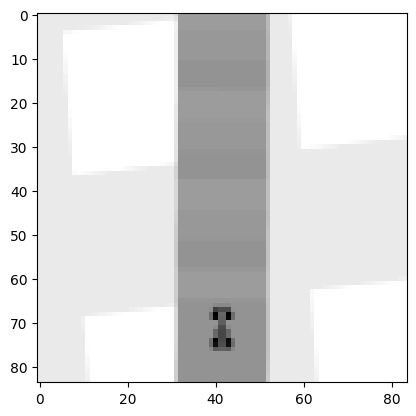

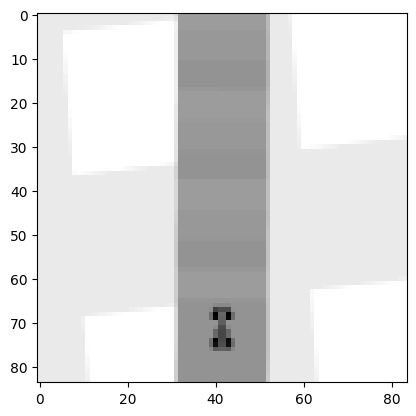

In [8]:
# Create environment
env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False, render_mode='rgb_array')
env = ImageEnv(env)
s,_ = env.reset()
plt.imshow(s[0],cmap='gray')
plt.show()
plt.imshow(s[1],cmap='gray')
plt.imshow(s[2],cmap='gray')
plt.imshow(s[3],cmap='gray')
plt.show()

In [9]:
#Creates checkpoint and raceNet directories to store target network weights later
def check_mkdir(path: str):
  if not os.path.exists(path):
    os.mkdir(path)
ckpt_path = './checkpoint'
exp_name = 'raceNet'
check_mkdir(ckpt_path)
check_mkdir(os.path.join(ckpt_path, exp_name))

In [10]:
#Printing out state sizes and testing action space sampling
s,_ = env.reset()
s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
print(s.shape)
print(env.action_space.sample())

torch.Size([1, 4, 84, 84])
2


In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

n_actions = env.action_space.n
state,_ = env.reset()
n_obj = (len(state),len(state[0][0]))

class CarAgent():
    def __init__(self, batch, learning_rate, epsilon, discount):
        self.batch_size = batch
        self.lr = learning_rate
        self.epsilon = epsilon
        self.discount = discount
        self.policy_net = carNet(n_obj, n_actions).to(device)
        self.target_net = carNet(n_obj, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(1000000)
        self.steps_done = 0

    def select_action(self, state):
        sample = random.random()
        self.steps_done += 1
        #Return action in a tensor
        if sample > self.epsilon:
            #Select epsilon greedy action
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1,1)
        else:
            #Select a random action
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    #Updating Network weights with batches of state action rewards
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)

        batch = Transition(*zip(*transitions))

        #Getting all batches that do not contain terminal states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        #Policy network state action values
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        #Target network state action values
        expected_states_action_values = (next_state_values * self.discount) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_states_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def test(self):
        culrew = 0
        culsteps = 0
        self.target_net.eval()
        for i in range(5):
            print("Test Episode: ",i)
            s,_ = env.reset()
            done = False
            while not done:
                s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
                a = self.target_net(s).max(1).indices.view(1,1)
                s_prime, r, terminate, trunc, info = env.step(a.item())
                s = s_prime
                culrew+=r
                culsteps+=1
                done = terminate or trunc
        self.target_net.train()
        return (culsteps/5), (culrew/5)


In [12]:
class carNet(nn.Module):
    def __init__(self, n_observations, n_acts):
        super(carNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(4, 8, 4, 2, 1),  nn.BatchNorm2d(8), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, 4, 1, 1),  nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(6400, 1024), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(1024, 128), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(128, n_acts))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #print(x.size())
        return self.fc3(x)

In [ ]:
#Printing out neural network chart
def s():
  p = carNet(0,5).cuda()
  summary(p, (4, 84, 84))

s()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             520
       BatchNorm2d-2            [-1, 8, 42, 42]              16
              ReLU-3            [-1, 8, 42, 42]               0
            Conv2d-4           [-1, 16, 41, 41]           2,064
       BatchNorm2d-5           [-1, 16, 41, 41]              32
              ReLU-6           [-1, 16, 41, 41]               0
         MaxPool2d-7           [-1, 16, 20, 20]               0
           Flatten-8                 [-1, 6400]               0
            Linear-9                 [-1, 1024]       6,554,624
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 5]             645
Total params: 6,689,101
Trainable param

In [13]:
#Storing transitions for batch training
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
avgrew = []
avgsteps = []
test_ep = []

trainrew = []
trainstep = []

def train(agent):
    episode_durations = []
    tau = 0.005
    num_episodes = 100
    if torch.cuda.is_available():
        num_episodes = 500
    for i in range(num_episodes):
        totrew = 0
        totstep = 0

        #Conditional to run tests every 10 episodes
        if (i+1) % 10 == 0:
            s,r = agent.test()
            avgrew.append(r)
            avgsteps.append(s)
            test_ep.append(len(test_ep)+1)
            print("Average reward: ", r)
            print("Average steps: ", s)
        print('Episode: ', i+1)

        #Obtaining current state from environment
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        #state = state.permute(0,3,1,2)
        for t in count():
            #print(t)
            #Selecting action from given state
            action = agent.select_action(state)
            #Getting reward and next state
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated
            next_state= None

            if not terminated:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                #next_state = next_state.permute(0,3,1,2)

            #Adding transitions into RBuffer
            agent.memory.push(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

            target_net_state_dict = agent.target_net.state_dict()
            policy_net_state_dict = agent.policy_net.state_dict()

            #Update the target network using the policy network and the update rate tau
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
            agent.target_net.load_state_dict(target_net_state_dict)

            totrew += float(reward.cpu())
            totstep += 1

            if done:
                episode_durations.append(t + 1)
                break
        trainrew.append(totrew)
        trainstep.append(totstep)
    agent.target_net.cpu()
    torch.save(agent.target_net.state_dict(), os.path.join(ckpt_path, 'raceNet', '%d.pth' % num_episodes))

    #Print out graphs for average rewards and average number of steps per test episode
    #5 test episodes are run after every 10 training episodes
    plt.plot(test_ep,avgrew)
    plt.title("Average Cumulative Reward During Test Episodes")
    plt.xlabel("Test Runs (5 episodes per test)")
    plt.ylabel("Average Reward")
    plt.show()
    plt.plot(test_ep,avgsteps)
    plt.title("Average Number of Steps During Test Episodes")
    plt.xlabel("Test Runs (5 episodes per test)")
    plt.ylabel("Average Number of Steps")
    plt.show()

    #Print out graphs for rewards and number of step per training episode
    xvals = [x for x in range(1,num_episodes+1)]
    plt.plot(xvals,trainrew)
    plt.title("Cumulative Reward Per Training Episode")
    plt.xlabel("Training Episode")
    plt.ylabel("Cumulative Reward")
    plt.show()
    plt.plot(xvals,trainstep)
    plt.title("Number of Steps Per Training Episode")
    plt.xlabel("Training Episodes")
    plt.ylabel("Number of Steps")
    plt.show

    env.close()

Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Test Episode:  0
Test Episode:  1
Test Episode:  2
Test Episode:  3
Test Episode:  4
Average reward:  -39.61506750489457
Average steps:  238.0
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Test Episode:  0
Test Episode:  1
Test Episode:  2
Test Episode:  3
Test Episode:  4
Average reward:  -29.020892913769707
Average steps:  217.4
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Test Episode:  0
Test Episode:  1
Test Episode:  2
Test Episode:  3
Test Episode:  4
Average reward:  36.68211351456232
Average steps:  236.6
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Test Episode:  0
Test Episode:  1
Test Episode:  2
Test Episode:  3
Test 

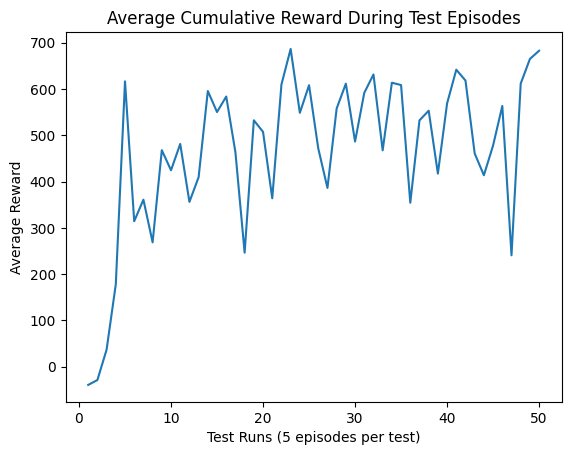

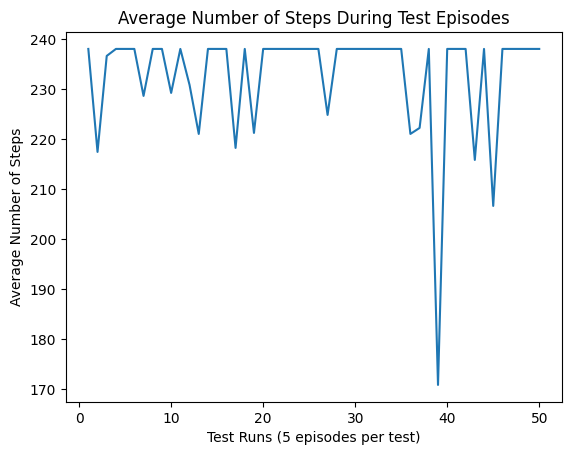

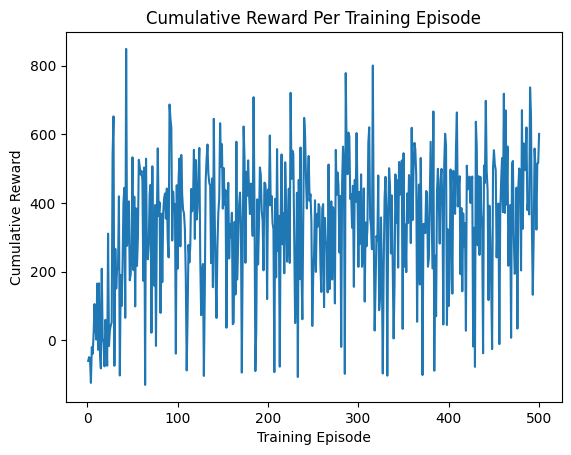

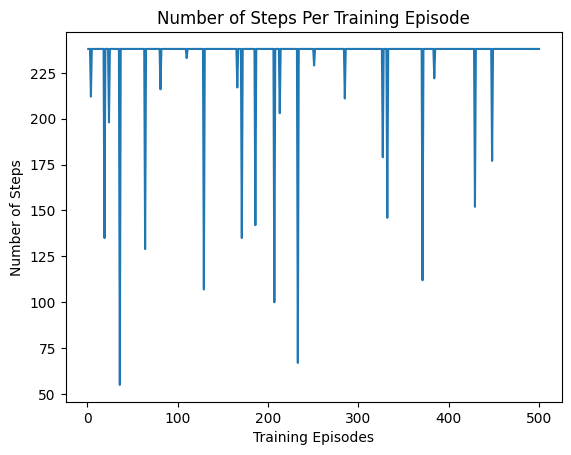

In [ ]:
def main():
    agent = CarAgent(32,0.0005,0.1,0.99)
    train(agent)

if __name__  == '__main__':
    main()

KeyboardInterrupt: 

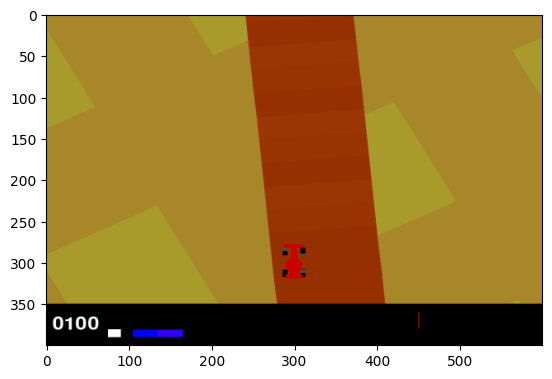

In [26]:
#Inference
#To run inference you need to have a raceNet pth file
#Outside the checkpoint directory
def main():
    net = carNet(n_obj,n_actions)
    net.load_state_dict(torch.load('raceNet.pth'))
    net.eval()

    s,_ = env.reset()
    done = False
    ret = 0
    img = plt.imshow(env.render())
    while not done:
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        a = net(s).max(1).indices.view(1,1)
        s_prime, r, terminate, trunc, info = env.step(a.item())
        s = s_prime
        done = terminate or trunc
    net.train()
main()